### Loading required libraries

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

### Unet

In [19]:
class SimpleUNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Time embedding
        self.time_embed = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 64),  # increased capacity
            nn.ReLU()
        )


        self.enc1 = nn.Conv2d(1, 64, 3, padding=1)
        self.enc2 = nn.Conv2d(64, 128, 3, padding=1)


        self.dec1 = nn.Conv2d(128, 64, 3, padding=1)
        self.dec2 = nn.Conv2d(64, 1, 3, padding=1)

        self.relu = nn.ReLU()
        self.norm1 = nn.BatchNorm2d(64)
        self.norm2 = nn.BatchNorm2d(128)

    def forward(self, x, t):
        t = t.float().view(-1, 1)
        t_embed = self.time_embed(t).view(-1, 64, 1, 1)


        x1 = self.relu(self.norm1(self.enc1(x) + t_embed))
        x2 = self.relu(self.norm2(self.enc2(x1)))


        x = self.relu(self.dec1(x2))
        x = self.dec2(x + x1)

        return x

### Diffusion

In [20]:
class Diffusion:
    def __init__(self, T=1000, beta_start=1e-4, beta_end=0.02):
        self.T = T
        self.betas = torch.linspace(beta_start, beta_end, T).to(device)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0).to(device)

    def forward(self, x0, t):
        # Corrupt data with noise at timestep `t`
        noise = torch.randn_like(x0)
        t = t.to(device)
        alpha_bar = self.alpha_bars[t].view(-1, 1, 1, 1)
        xt = torch.sqrt(alpha_bar) * x0 + torch.sqrt(1 - alpha_bar) * noise
        return xt, noise

### Training

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SimpleUNet().to(device)
diffusion = Diffusion(T=1000)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
dataset = datasets.MNIST(root="data", train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# Train for 10 epochs (short demo)
for epoch in range(10):
    for x0, _ in dataloader:
        x0 = x0.to(device)
        t = torch.randint(0, diffusion.T, (x0.shape[0],)).to(device)
        xt, noise = diffusion.forward(x0, t)
        pred_noise = model(xt, t)
        loss = F.mse_loss(pred_noise, noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 0.0398
Epoch 1, Loss: 0.0342
Epoch 2, Loss: 0.0341
Epoch 3, Loss: 0.0294
Epoch 4, Loss: 0.0304
Epoch 5, Loss: 0.0303
Epoch 6, Loss: 0.0242
Epoch 7, Loss: 0.0215
Epoch 8, Loss: 0.0302
Epoch 9, Loss: 0.0334


### New data points generation

In [16]:
def generate_samples(model, diffusion, num_samples=16, device="cpu"):
    model.eval()
    with torch.no_grad():
        x = torch.randn(num_samples, 1, 28, 28).to(device)
        for t in reversed(range(diffusion.T)):
            t_tensor = torch.full((num_samples,), t, dtype=torch.long).to(device)
            pred_noise = model(x, t_tensor)

            alpha_t = diffusion.alphas[t]
            alpha_bar_t = diffusion.alpha_bars[t]
            beta_t = diffusion.betas[t]

            # Compute mean
            mean = (x - (beta_t / torch.sqrt(1 - alpha_bar_t)) * pred_noise) / torch.sqrt(alpha_t)

            # Add noise
            if t > 0:
                noise = torch.randn_like(x)
            else:
                noise = 0
            x = mean + torch.sqrt(beta_t) * noise

        x = torch.clamp(x, -1, 1).cpu().numpy()
        return x

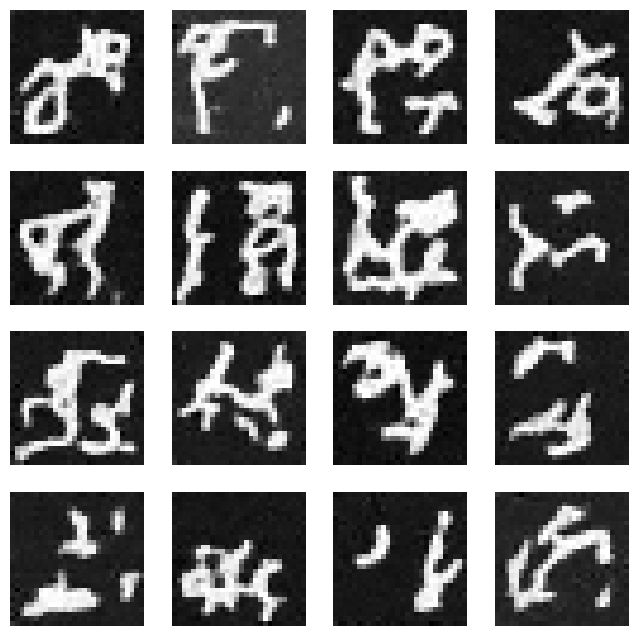

In [17]:
samples = generate_samples(model, diffusion, num_samples=16, device=device)

fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(samples[i].squeeze(), cmap="gray")
    ax.axis("off")
plt.show()
